# VAE with MMD objective on MNIST dataset:

In [0]:
import os, sys, math
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
import random

seed = 40569
random.seed(seed)

import torch.nn as nn
import torch.nn.functional as F


#based on:
#https://github.com/ShengjiaZhao/InfoVAE/blob/master/mmd_vae.ipynb
#https://github.com/atinghosh/VAE-pytorch/blob/master/VAE_CNN_BCEloss.py
#https://github.com/sksq96/pytorch-vae/blob/master/vae-cnn.ipynb

In [0]:
batch_size = 200
z_dim = 20
padding = 1

In [0]:
def lrelu(tens, rate=0.1):
    return torch.max(torch.min(x * rate, 0), x)

In [0]:
class Encoder(nn.Module):
    
    def __init__(self, z_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 4, stride=2, padding=padding)
        self.conv2 = nn.Conv2d(64, 128, 4, stride=2, padding=padding)
        self.fc1 = nn.Linear(7*7*128, 1024)
        self.fc2 = nn.Linear(1024, z_dim)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), negative_slope=0.1)
        x = F.leaky_relu(self.conv2(x), negative_slope=0.1)
        x = x.view(-1, np.array(x.shape)[1:].prod())
        x = F.leaky_relu(self.fc1(x))
        return self.fc2(x)

In [0]:
class Decoder(nn.Module):
    
    def __init__(self, z_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(z_dim, 1024)
        self.fc2 = nn.Linear(1024, 7*7*128)
        self.conv1 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=padding)
        self.conv2 = nn.ConvTranspose2d(64, 1, 4, stride=2, padding=padding)
        
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = x.view(-1, 128, 7, 7)
        x = F.relu(self.conv1(x))
        x = self.conv2(x)
        return F.sigmoid(x)

In [0]:
def compute_kernel(x, y):
    
    x_size = x.shape[0]
    y_size = y.shape[0]
    dim = x.shape[1]
    tiled_x = x.view(x_size, 1, dim).repeat(1, y_size, 1)
    tiled_y = y.view(1, y_size, dim).repeat(x_size, 1, 1)
    return torch.exp(- torch.mean((tiled_x - tiled_y)**2, dim=2) / float(dim))
    
def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    return (x_kernel + y_kernel - 2 * xy_kernel).mean()

In [0]:
class infoVAE(nn.Module):
    
    def __init__(self, image_channels=1, z_dim=z_dim):
        super(infoVAE, self).__init__()
        self.z_dim = z_dim
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
        
    def forward(self, x):
        z = self.encoder(x)
        if self.training:
            return z, self.decoder(z)
        else:
            return self.decoder(z)
    
    def loss_nll(self, x, x_recon):
        return ((x_recon - x)**2).mean()  #F.mse_loss(x_recon, x)
    
    def loss_mmd(self, z, batch_size=batch_size):
        true_samples = torch.randn(batch_size, self.z_dim)
        return compute_mmd(true_samples, z)
    
    def loss_function(self, x, x_recon, z, batch_size=batch_size):
        return self.loss_nll(x, x_recon) + self.loss_mmd(z, batch_size)

In [0]:
vae = infoVAE()

In [0]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [0]:
from torchvision import datasets

path = './MNIST_data'
if not os.path.exists(path):
    os.makedirs(path)

data = datasets.MNIST(path, train=True, download=False)#.train_data#.view(-1).float()


In [0]:
data.train_data[0*200:1*200].shape

torch.Size([200, 28, 28])

In [0]:
ls_shuffle = list(range(60000))
random.shuffle(ls_shuffle)
split = 0.8

In [0]:
epochs = 1 #7 #10 #laptop shuts down if too long...
height = data.train_data.shape[-2]
width = data.train_data.shape[-1]
train_data = data.train_data[ls_shuffle[:math.ceil(split * 60000)]].type('torch.FloatTensor')/255.
val_data = data.train_data[ls_shuffle[math.ceil(split * 60000):]].type('torch.FloatTensor')/255.

In [0]:
nb_batches = len(train_data)//batch_size

for epoch in range(epochs):
    for id_batch in range(nb_batches):
        data_batch = train_data[(batch_size * id_batch):((id_batch + 1) * batch_size)]
        data_batch = data_batch.view(batch_size, 1, height, width)
        
        z_batch, data_batch_recon = vae(data_batch)
        mmd_loss = vae.loss_mmd(z_batch)
        nll_loss = vae.loss_nll(data_batch, data_batch_recon)
        loss = nll_loss + mmd_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if not id_batch % 10:
            print(f'Epoch {epoch + 1}/{epochs}, Batch {id_batch}/{nb_batches}, Loss MMD: {mmd_loss}; Loss NLL: {nll_loss}')

C:\Users\Raphael\Anaconda3bis\lib\site-packages\torch\nn\functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 1/1, Batch 0/240, Loss MMD: 0.0029935224447399378; Loss NLL: 0.22738629579544067
Epoch 1/1, Batch 10/240, Loss MMD: 0.003536537056788802; Loss NLL: 0.09845829755067825
Epoch 1/1, Batch 20/240, Loss MMD: 0.0032503947149962187; Loss NLL: 0.07405422627925873
Epoch 1/1, Batch 30/240, Loss MMD: 0.0037527228705585003; Loss NLL: 0.06648081541061401
Epoch 1/1, Batch 40/240, Loss MMD: 0.002876213053241372; Loss NLL: 0.06314099580049515
Epoch 1/1, Batch 50/240, Loss MMD: 0.0026682165917009115; Loss NLL: 0.061244841665029526
Epoch 1/1, Batch 60/240, Loss MMD: 0.002480186754837632; Loss NLL: 0.060042157769203186
Epoch 1/1, Batch 70/240, Loss MMD: 0.002717655850574374; Loss NLL: 0.05873427540063858
Epoch 1/1, Batch 80/240, Loss MMD: 0.0025585328694432974; Loss NLL: 0.05699756741523743
Epoch 1/1, Batch 90/240, Loss MMD: 0.0019548877608031034; Loss NLL: 0.05283309146761894
Epoch 1/1, Batch 100/240, Loss MMD: 0.002437023678794503; Loss NLL: 0.04798408970236778
Epoch 1/1, Batch 110/240, Loss MMD:

C:\Users\Raphael\Anaconda3bis\lib\site-packages\torch\nn\functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


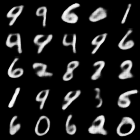

In [0]:
import PIL.Image

sqrt_ex = 5

arr = np.zeros((sqrt_ex * 28, sqrt_ex * 28), dtype='uint8')

for i in range(sqrt_ex):
    for j in range(sqrt_ex):
        arr[i*28:(i+1)*28, j*28:(j+1)*28] = ((vae(val_data[i + 5*j].view(1, 1, height, width)))[1]*255.).type('torch.IntTensor').view(28, 28).numpy().astype('uint8')

#print(type(arr), arr.shape, arr.dtype)
PIL.Image.fromarray(arr, 'L')


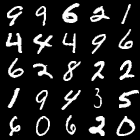

In [0]:
or_arr = np.zeros((sqrt_ex * 28, sqrt_ex * 28), dtype='uint8')

for i in range(sqrt_ex):
    for j in range(sqrt_ex):
        or_arr[i*28:(i+1)*28, j*28:(j+1)*28] = (val_data[i + 5*j]*255.).type('torch.IntTensor').numpy().astype('uint8')
        
PIL.Image.fromarray(or_arr, 'L')

In [0]:
z_test_rand = torch.randn(20)

In [0]:
gen_arr_test = (vae.decoder(z_test_rand)*255).type('torch.IntTensor').view(28, 28).numpy().astype('uint8')

C:\Users\Raphael\Anaconda3bis\lib\site-packages\torch\nn\functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [0]:
PIL.Image.fromarray(gen_arr_test, 'L')